Data shape: (498000, 32, 32, 2)
Labels shape: (498000,)
ResNet15(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

<ipython-input-1-7ab0271ae581>:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet15_model.pth"))


Predicted labels: [1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1]
True labels:      [1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1]


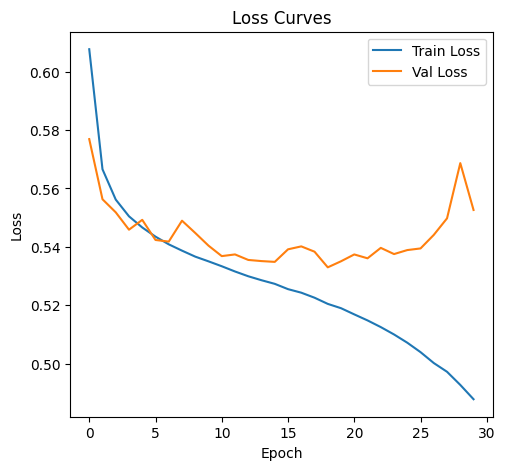

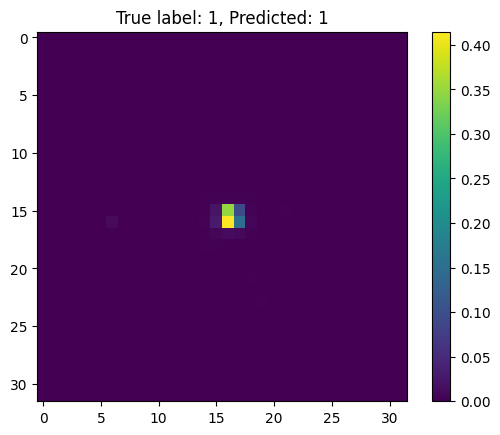

In [1]:
# %% [markdown]
# # Particle Classification with a ResNet-15 Model (Revised)
#
# This notebook demonstrates how to build a deep learning model to classify particles (electrons vs. photons)
# using 32×32 images with two channels (hit energy and time). In this revised version, we no longer inject noise
# into the images since our analysis shows that only about 0.10% of the images are completely zero.
#

# %% [code]
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def load_hdf5_data(file_path):
    with h5py.File(file_path, 'r') as f:
        X = f["X"][:]  # shape (n_samples, 32, 32, 2)
        y = f["y"][:]  # provided labels (if any)
    return X, y

# Paths to the files (update paths if necessary)
electron_file = "/kaggle/input/dataelectronandphoton/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
photon_file   = "/kaggle/input/dataelectronandphoton/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

# Load the data
X_electron, _ = load_hdf5_data(electron_file)
X_photon, _   = load_hdf5_data(photon_file)

# Create labels based on the file source
y_electron = np.ones(len(X_electron), dtype=np.int64)
y_photon   = np.zeros(len(X_photon), dtype=np.int64)

# Combine the two datasets
X_all = np.concatenate([X_electron, X_photon], axis=0)  # shape (N, 32, 32, 2)
y_all = np.concatenate([y_electron, y_photon], axis=0)

print("Data shape:", X_all.shape)
print("Labels shape:", y_all.shape)

# %% [markdown]
# ## Dataset and Data Augmentation
#
# In this version, we remove the noise injection since the percentage of completely zero images is negligible.
# We only apply a simple transformation that rearranges the image dimensions to match PyTorch's expected format.
#

# %% [code]
class ParticleDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # expected shape (N, 32, 32, 2)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]  # shape (32, 32, 2)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        # Rearrange from H x W x C to C x H x W (as expected by PyTorch)
        image = np.transpose(image, (2, 0, 1))
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Define the transformation pipeline
# (Optional: add normalization or other augmentations if needed)
data_transforms = transforms.Compose([
    # For example, you can uncomment the following to normalize based on dataset statistics:
    # transforms.Lambda(lambda img: (img - np.mean(img)) / (np.std(img) + 1e-8))
])

dataset = ParticleDataset(X_all, y_all, transform=data_transforms)

# Split into train and validation sets (e.g., 80/20 split)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# %% [markdown]
# ## Model Definition: A ResNet-15–like Model
#
# Below is a custom ResNet-like architecture with roughly 15 layers. We have modified the network so that it
# works well with our 32×32 input images.
#

# %% [code]
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, in_channels=2):
        super(ResNet15, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        # For 32x32 images, the final spatial size will be small. Adjust the pooling accordingly.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # [B,16,32,32]
        out = self.layer1(out)                 # [B,16,32,32]
        out = self.layer2(out)                 # [B,32,16,16]
        out = self.layer3(out)                 # [B,64,8,8]
        out = self.layer4(out)                 # [B,128,4,4] (or smaller)
        out = self.avgpool(out)                # [B,128,1,1]
        out = out.view(out.size(0), -1)          # [B,128]
        out = self.fc(out)                     # [B,num_classes]
        return out

# Create a ResNet-15 variant.
# We choose num_blocks such that total layers approximate 15:
# For example, num_blocks = [2, 2, 2, 2] gives a balanced architecture.
model = ResNet15(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=2, in_channels=2)
print(model)

# %% [markdown]
# ## Training the Model
#
# We set up a training loop using Adam optimizer and Cross Entropy loss.
#

# %% [code]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
train_losses = []
val_losses = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    
    # Save best model weights
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet15_model.pth")

print("Training complete. Best validation accuracy: {:.4f}".format(best_val_acc))

# %% [markdown]
# ## Plotting Training Curves
#

# %% [code]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curves")

# %% [markdown]
# ## Inference Example
#
# Finally, here's how to load the saved model and run inference on a batch.
#

# %% [code]
# Load best model weights for inference
model.load_state_dict(torch.load("best_resnet15_model.pth"))
model.eval()

# Get a batch from validation set and show predictions
images, labels = next(iter(val_loader))
images = images.to(device)
outputs = model(images)
_, predicted = outputs.max(1)
print("Predicted labels:", predicted.cpu().numpy())
print("True labels:     ", labels.numpy())

# Optionally, display one of the images
img = images[0].cpu().numpy().transpose(1,2,0)
plt.figure()
plt.imshow(img[:,:,0], cmap='viridis')  # display first channel (e.g., hit energy)
plt.title(f"True label: {labels[0].item()}, Predicted: {predicted[0].item()}")
plt.colorbar()
plt.show()



Combined data shape: (498000, 32, 32, 2)
Combined labels shape: (498000,)
Training set: (398400, 32, 32, 2) (398400,)
Validation set: (99600, 32, 32, 2) (99600,)


/usr/local/lib/python3.10/dist-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,584,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,588,674 (89.98 MB)

 Trainable params: 23,535,554 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 378s 26ms/step - accuracy: 0.5458 - loss: 0.8146 - val_accuracy: 0.5944 - val_loss: 0.6691
Epoch 2/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 324s 26ms/step - accuracy: 0.6128 - loss: 0.6868 - val_accuracy: 0.6667 - val_loss: 0.6199
Epoch 3/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 341s 27ms/step - accuracy: 0.6703 - loss: 0.6218 - val_accuracy: 0.6861 - val_loss: 0.6009
Epoch 4/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 345s 28ms/step - accuracy: 0.6822 - loss: 0.6048 - val_accuracy: 0.6878 - val_loss: 0.5955
Epoch 5/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 346s 28ms/step - accuracy: 0.6942 - loss: 0.5906 - val_accuracy: 0.7009 - val_loss: 0.5837
Epoch 6/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 346s 28ms/step - accuracy: 0.7016 - loss: 0.5819 - val_accuracy: 0.7067 - val_loss: 0.5752
Epoch 7/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 331s 27ms/step - accuracy: 0.7076 - loss: 0.5754 - val_accuracy: 0.6657 - val_loss: 0.6106
Epoch 8/30
12450/12450 ━━━━━━━━━━━━━━━━━━━━ 325s 26ms/s

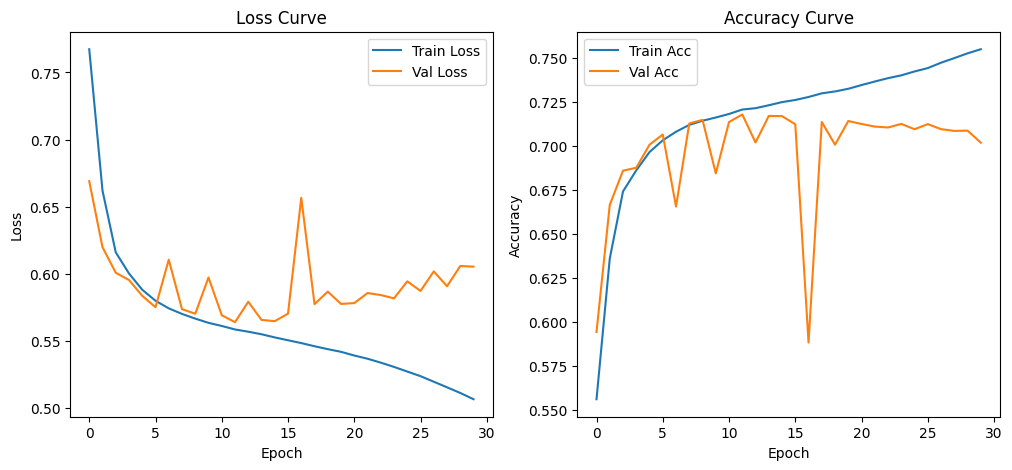

In [2]:
# %% [markdown]
# # Particle Classification using TensorFlow and a Pre-Existing ResNet Model
#
# In this notebook, we:
#
# 1. Load the electron and photon datasets from HDF5 files.
# 2. Assign labels: electrons are labeled as 1, photons as 0.
# 3. Create training and validation splits.
# 4. Build a model using a pre-existing ResNet architecture from tf.keras.applications.
#
# **Note:** Since the built-in ResNet models typically expect 3-channel input and larger resolutions,
# we set `weights=None` so that we can specify our custom input shape (32×32 with 2 channels).

# %% [code]
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("Combined data shape:", X_all.shape)
print("Combined labels shape:", y_all.shape)

# %% [markdown]
# ### Train/Validation Split
#
# We use an 80/20 split for training and validation.

# %% [code]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

# %% [markdown]
# ### Create TensorFlow Datasets
#
# We create `tf.data.Dataset` objects for efficient batching and prefetching.
#
# **Optional:** You can add further preprocessing or normalization steps.

# %% [code]
batch_size = 32

def preprocess(image, label):
    # Optionally, normalize images here, for example:
    image = tf.cast(image, tf.float32)
    # Uncomment and adjust the following line if you want to normalize:
    # image = (image - tf.reduce_mean(image)) / (tf.math.reduce_std(image) + 1e-8)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# %% [markdown]
# ## Build the Model using a Pre-Existing ResNet
#
# We use a ResNet50 model from `tf.keras.applications` but set `weights=None` so that we can change the input shape.
# We remove the top and add our own classification head.

# %% [code]
input_shape = (32, 32, 2)  # our images have 2 channels

# Create a base model using ResNet50 with custom input shape and no pre-trained weights.
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=input_shape,
    pooling='avg'
)

# Build the complete model.
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
outputs = layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# %% [markdown]
# ## Compile and Train the Model
#
# We compile the model using the Adam optimizer and sparse categorical crossentropy loss,
# then train for a number of epochs.

# %% [code]
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

# %% [markdown]
# ## Plot Training Curves

# %% [code]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# %% [markdown]
# ## Inference Example